In [24]:
#!pip install pyswarms==0.2.1
#!pip install pyswarms==0.2.0
!pip install pyswarms

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [46]:

from google.colab import drive
import sys
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import pyswarms as ps
from pyswarms.utils.environments import PlotEnvironment
#import pyswarms.discrete
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification 
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from IPython.display import display

from datetime import datetime as dt
import time



In [47]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


WE WILL BE GENERATING AN ARTIFICIAL DATA

In [49]:
'''x, y = make_classification(n_samples = 500, n_features = 20, n_classes = 2, n_informative = 5,
                           n_redundant = 0, n_repeated = 0,
                           random_state = None, shuffle = True)
    '''                       

'x, y = make_classification(n_samples = 500, n_features = 20, n_classes = 2, n_informative = 5,\n                           n_redundant = 0, n_repeated = 0,\n                           random_state = None, shuffle = True)\n    '

In [ ]:
#x.shape

In [51]:
parkDF = pd.read_csv('/content/drive/MyDrive/Datasets/parkinsons.csv')

In [52]:
parkDF.shape

(195, 24)

In [53]:
#parkDF.isnull().sum()
parkDF.head(5)
#parkDF.info()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


The label is n0t at the appropriate position, thus it has to be moved.

In [54]:
#we extracted the label away from the entire data
y = parkDF[['status']]

In [55]:
#we dropped the label or class from the dataset to have only features
x = parkDF.drop('status', axis = 1)


In [ ]:
#we checked the balance nature of the label class
#y.value_counts().plot(kind = 'bar')

In [56]:
#we need to transform the name column into numerical
x['name'] = LabelEncoder().fit_transform(x['name'])

In [57]:
#we need to convert the name column into an interger
#Also, we need to convert the negative columns into positive. lets create a copy of the features
x1 = x.copy()
x1['spread1'] = abs(x1['spread1'])

In [ ]:
#x1

In [59]:
from pandas.core.tools.numeric import to_numeric
x1['name'] = pd.to_numeric(x1['name'])

In [ ]:
#x1.info()
#y

In [60]:
#Converting dataframes to numpy arrays
x1 = x1.values
y = y.values

In [ ]:
#x1.shape

In [ ]:
#parkDFCombine = pd.concat([x1,y], axis = 1)

In [ ]:
#parkDFCombine

We want to plot a toy dataset per feature

In [ ]:
#sns.pairplot(parkDFCombine, hue = 'status')

We will then use a simple logistic regression technique using sklearn.linear_model.LogisticRegression to perform classification. A simple test of accuracy will be used to assess the performance of the classifier.

## Writing the custom-objective function
As seen above, we can write our objective function by simply taking the performance of the classifier (in this case, the accuracy), and the size of the feature subset divided by the total (that is, divided by 10), to return an error in the data. We'll now write our custom-objective function

In [61]:
#we first of all create an instance of the class LogisticRegression
classifier = LogisticRegression()

## **Define objective function**

In [62]:
def f_per_particle(m, alpha):
    total_features = x1.shape[1] #this returns the number of features i.e., 1 stands for columns and 0 for rows
    if np.count_nonzero(m) == 0: #if the particle subset is only zeros, get the original set of attaributes
      x1_subset = x1
    else:
      x1_subset = x1[:,m==1]

    scores = cross_val_score(classifier, x1_subset, y, cv = 3)
    P = scores.mean()
    particlesScore.append(P)
    particlesSize.append(x1_subset.shape[1])
    
    #Now we compute the objective function
    j = (alpha * (1.0 - P) 
        + (1.0 - alpha)*(1 - (x1_subset.shape[1] / total_features)))
    return j

In [63]:
def f(x1, alpha = 0.9):
    n_particles = x1.shape[0] #defining number of particles to be equal to the number of samples in the dataset
    j = [f_per_particle(x1[i], alpha) for i in range(n_particles)]
    #print('function of j: ',j)
    return np.array(j)

# Using Binary PSO
With everything set-up, we can now use Binary PSO to perform feature selection. For now, we'll be doing a global-best solution by setting the number of neighbors equal to the number of particles. The hyperparameters are also set arbitrarily. Moreso, we'll also be setting the distance metric as 2 (truth is, it's not really relevant because each particle will see one another).

In [64]:
start = dt.now() #representing the starting time of a task/process
print ('started at: ', str(start))
particlesScore = list()
particlesSize = list()

#initialize swarm arbitrary
opt = {'c1': 2, 'c2': 2, 'w': 0.3, 'k': 20, 'p': 2} 
'''where k= number of neighbors to be considered. Must be a
positive integer less than n_particles, p = Enclidean or L2 distance'''

started at:  2023-02-03 22:05:46.058491


'where k= number of neighbors to be considered. Must be a\npositive integer less than n_particles, p = Enclidean or L2 distance'

In [65]:
#Call instance of PSO
dim = x1.shape[1] #dimensions is the number of features/variables in the dataset
optimizer = ps.discrete.BinaryPSO(n_particles = 20, dimensions = dim, options=opt, velocity_clamp= (-1,1))
#optimizer = ps.discrete.BinaryPSO(n_particles = 20, dimensions = dim, options = opt)
#cost, pos = optimizer.optimize(f, iters=10, )

In [ ]:
#Initialize the plot environment
plt_env = PlotEnvironment(optimizer, f, 20) #Where 10 stands for number of iterations

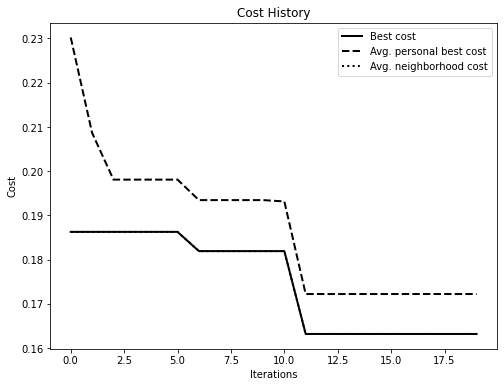

Finished at Exactly:  2023-02-03 22:13:53.108279
Total duration of time is:  0:08:07.049788


In [70]:
#plot the cost
plt_env.plot_cost(figsize = (8,6));
plt.show()
end = dt.now()
print('Finished at Exactly: ', str(end))
print('Total duration of time is: ', str(end - start))

In [ ]:
print(optimizer.get_mean_pbest_history)
#print(optimizer.personal_best_pos[5])

## **SOMEDAY I MIGHT CONTINUE. BUT I LEARNT A GREAT DEAL FROM THIS PROJECT.**